#

In [1]:
%matplotlib inline

from py4xs.hdf import h5xs,h5exp,lsh5
import pylab as plt
import numpy as np
import warnings,json

warnings.filterwarnings('ignore')

## Detector configuration assignment

Before data processing can start, the detector configurations need to be assoicated with the h5 file. If the detector information has been previously saved, it can be recalled automatically.

In [2]:
dt = h5xs("data/AgBH-2020Aug16.h5")

The h5 file itself can be accessed using the fh5 attribute of the h5xs object.

## h5 data organization 

The h5 file packaged at the LiX beamline is a selected copy of information from the NSLS-II databroker, 
organized by sample, stream, then data groups. This data structure can be visualized using a viewer like
hdfview, or using the lsh5() function. For instance:

In [3]:
dt.explict_open_h5()
lsh5(dt.fh5, print_attrs=False, )
dt.explicit_close_h5()

 AgBH_2020Aug16
= primary
== data
=== em1_sum_all_mean_value
=== em2_current1_mean_value
=== em2_current2_mean_value
=== em2_sum_all_mean_value
=== pil1M_image
=== pilW2_image
== time
== timestamps
=== em1_sum_all_mean_value
=== em2_current1_mean_value
=== em2_current2_mean_value
=== em2_sum_all_mean_value
=== pil1M_image
=== pilW2_image
= processed
== _SAXS
== _WAXS2
== merged


**Note**: in fly scans, the monitor data (transmitted beam intensity) are recorded in separate streams from *primary*. These data typically do not have the same time stamps. The fast axis also moves in the snake pattern to save time. Thefore the position of the fast-axis motor and the corresponding monitor counts may not be accessed by simple indexing.   

## Generation of intensity maps/profiles 

Currently py4xs provides batch processing to perform aximuthal average on all data contained in the h5 file, including averaging on each detector, then merging the data from multiple detectors. This will create new data under the *processed* group. 

In [4]:
dt.load_data()

data received: sn=AgBH_2020Aug16, fr1=0


In [5]:
list(dt.d1s.keys())

['AgBH_2020Aug16']

In [6]:
list(dt.d1s[dt.samples[0]].keys())

['merged', '_SAXS', '_WAXS2']

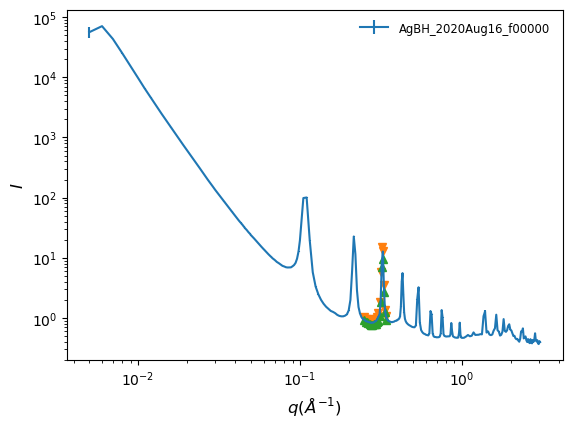

In [7]:
dt.d1s[dt.samples[0]]['merged'][0].plot()

Batch processing for 2D data conversion will eventually become avialable, once decisions are made on what values will be used for the $q$ and $\phi$ grid, and utilities are put in place to save and load the converted data. For now this kind of conversion can be performs frame by frame, as shown in the previous example.

In [41]:
d2s = dt.get_d2(det_ext="_SAXS", frn=0)
d2s.conv_Iqphi(100, 31, mask=dt.detectors[0].exp_para.mask)
mm = d2s.qphi_data.copy()
mm.xc_label = "q $(\AA^{-1})$"
mm.yc_label = "$\phi (deg)$"

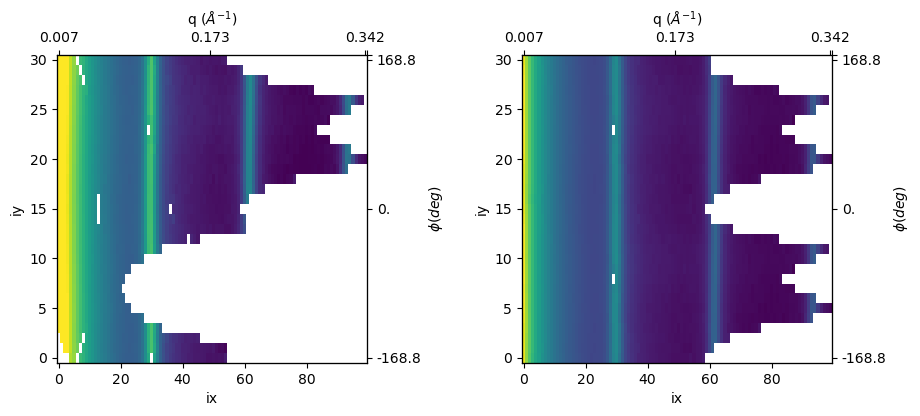

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(121)
mm.plot(aspect="auto", logScale=True, ax=plt.gca())
plt.subplot(122)
mm.apply_symmetry().plot(aspect="auto", logScale=True, ax=plt.gca())
plt.subplots_adjust(wspace=0.5)

## Background subtraction

Background subtraction is essential, especially for samples that do not produce prominet diffraction peaks. During the experiments, be sure that empty cell scattering is measured. This may be position-dependent if the sample is measured in air. The scattering intensity must be scaled based on the transmitted beam intensity before subtraction. The hdf5 data group for the beam intensity monitors are specified in `py4xs.local`. The use code simply needs to specify the appropriate `transMode`. For fly scanning, monitors are not used as detectors in the context of Bluesky scans, therefore the `trigger` (name of the scanning motor) should also be specified. See docs for `py4xs.hdf.set_trans()` .  

In [10]:
from py4xs.slnxs import trans_mode
dt.set_trans(transMode=trans_mode.external)

attempting to run get_mon() first ...
em2 used as a detector.
em1 used as a detector.


In [11]:
dt.d1s[dt.samples[0]]['merged'][0].trans

31141.463999999964

## Feature extraction
Extracting features from the processed 1D or 2D data should be straightforward. This will mainly rely on the code provided by the user, and very specific to the type of structures only the user may be kownledgable of. Some generic functions are trivial to implement. For instance, *numpy* can be used to integrate intensity in a given $q$-range or calculate the center-of-mass of a angular distribution. Others are more complex to implement and could be included in py4xs, e.g. peak finding (assuming that there are only a handful). Requests may be entertained.

Additional functionalies have been implemented under `lixtools` to support scanning mapping and tomopgraphy data analysis.

## Parallelization

Currently py4xs makes use of multi-processing when batch processing the data (in `load_data()`). The number of processes used
can be specified. Note that the gain in procesing speed is not linearly proportional
to the number of processes used. And sometimes a single process needs to be used to avoid crashes.
